In [6]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import chainer
import chainer.functions as F
import chainer.links as L
import chainer.initializers as I

from ipywidgets import widgets
from ipywidgets.widgets import *
from IPython.display import display

In [336]:
class Model:
    def __init__(self,vx,vy,drag=1e-4):
        self.x = 0 # Fixed
        self.y = 0
        self.vx = float(vx)
        self.vy = float(vy)
        self.drag = drag
    
    def tick(self,dt):
        self.x += self.vx * dt
        self.y += self.vy * dt
        speed = (self.vx ** 2 + self.vy ** 2) ** .5
        braking_factor = max(0, 1 - speed * self.drag * dt)
        self.vx *= braking_factor
        self.vy *= braking_factor
        self.vy += -9.8 * dt

In [370]:
def trace_trajectory(vx=1000,vy=300,targetx=100000,drag=1e-4):
    m = Model(vx,vy,drag=drag)
    trajectory = np.array([(m.tick(t), (m.x, m.y))[1] for t in np.arange(0,10,0.1)])
    #print(m.vx, m.vy)
    return trajectory, max(0, np.interp(targetx, trajectory[:,0], trajectory[:,1]))

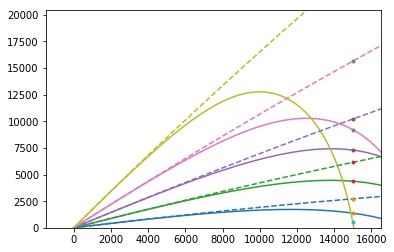

In [712]:
thetas = np.linspace(0,np.pi/3,6)[1:]
targetx = 15000
speed = 1500
for theta in thetas:
    trajectory, dist = trace_trajectory(speed * np.cos(theta), speed * np.sin(theta), targetx=targetx)
    plt.plot(trajectory[:,0], trajectory[:,1])
    plt.plot(targetx, dist, '.')
plt.xlim(xmin=-targetx * .1, xmax=targetx * 1.1)
plt.ylim(ymin=0)
for theta in thetas:
    trajectory, dist = trace_trajectory(speed * np.cos(theta), speed * np.sin(theta), targetx=targetx, drag=0)
    plt.plot(trajectory[:,0], trajectory[:,1], '--')
    plt.plot(targetx, dist, '.')

In [273]:
class Regressor(chainer.Chain):
    def __init__(self, outputs=1, n_units=128, outputfun=F.relu):
        import chainer.initializers as I
        w = I.Normal(0.005)
        self.outputfun = outputfun
        super(Regressor, self).__init__(
            l1 = L.Linear(None, n_units, initialW=w),
            l2 = L.Linear(n_units, outputs, initialW=w)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = self.l2(h1)
        return self.outputfun(h2)

In [274]:
class Regressor2(chainer.Chain):
    def __init__(self, outputs=1, n_units=128, outputfun=F.sigmoid):
        self.outputfun = outputfun
        super(Regressor2, self).__init__(
            l1 = L.Linear(None, n_units),
            l2 = L.Linear(n_units, n_units),
            l3 = L.Linear(n_units, outputs)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.outputfun(self.l3(h2))

In [952]:
class Regressor3(chainer.Chain):
    def __init__(self, outputs=1, n_units=128, outputfun=F.sigmoid):
        import chainer.initializers as I
        w = I.Normal(0.005)
        self.outputfun = outputfun
        super(Regressor3, self).__init__(
            l1 = L.Linear(None, n_units, initialW=w),
            l2 = L.Linear(n_units, n_units, initialW=w),
            l3 = L.Linear(n_units, n_units, initialW=w),
            l4 = L.Linear(n_units, outputs, initialW=w)
        )

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = F.relu(self.l3(h2))
        return self.outputfun(self.l4(h3))

In [1017]:
class MyTrainer:
    def __init__(self, regularize=0.0001, model=None, model_class=Regressor, n_units=128, outputs=1, optimizer=None, outputfun=F.sigmoid, lossfun=F.mean_squared_error):
        self.regularize = regularize
        if model == None:
            model = model_class(outputs, n_units, outputfun=outputfun)
            model.zerograds()
        self.model = model
        if optimizer == None:
            optimizer = chainer.optimizers.Adam()
            optimizer.setup(model)
            optimizer.add_hook(chainer.optimizer.WeightDecay(regularize))
        self.optimizer = optimizer
        self.lossfun = lossfun
        self.loss_hist = []
        self.total_i = 0

    def run_train(self, trainx, trainy, epoch=10000, report_period=100, report_period_seconds=0):
        from time import clock
        start = clock()
        last_report = start
        loss_hist = []

        try:
            for i in range(epoch):
                loss = self.lossfun(self.model(trainx), trainy)
                loss_hist.append(loss.data)
                if i % report_period == 0:
                    if last_report + report_period_seconds < clock():
                        ups = i / (clock() - start)
                        eta = (epoch - i) / ups if ups != 0 else 0
                        etas = '%d:%05.2f' % (eta // 60, eta % 60) if 60 < eta else '%.2f' % eta
                        print('[{}/{}]'.format(i,self.total_i), 'loss', loss.data, ', ups: %.2f' % ups, ', eta: ' + etas)
                        last_report = clock()
                self.total_i += 1
                #optimizer.weight_decay(0.005)
                self.optimizer.update(lambda x,y: self.lossfun(self.model(x), y), trainx, trainy)
        except KeyboardInterrupt:
            print('Interrupted')

        self.loss_hist += loss_hist

        return loss_hist

200 200 0.5 1.5707964
(200, 200) (200, 200) float32 float32
ST.shape (40000, 2)
trainx: (40000, 2) float32 -0.499998 1.7764676 trainy: (40000, 2) float32 1.5707964


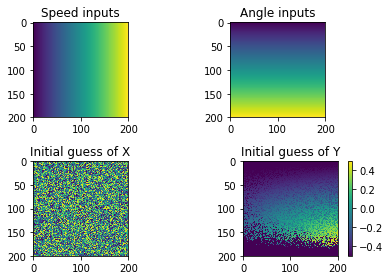

In [1161]:
    speed_scale = 2000
    position_scale = 10000
    speeds = np.linspace(500,1000,200,dtype=np.float32) / speed_scale
    thetas = np.linspace(0,np.pi/2,200,dtype=np.float32)
    print(len(speeds), len(thetas), speeds.max(), thetas.max())
    S, T = np.meshgrid(speeds, thetas)
    print(S.shape, T.shape, S.dtype, T.dtype)
    ST = np.vstack([S.flat, T.flat]).astype(np.float32).T
    print('ST.shape', ST.shape)
    fig, ax = plt.subplots(2,2)
    ax[0,0].imshow(S)
    ax[0,0].set_title('Speed inputs')
    ax[0,1].imshow(T)
    ax[0,1].set_title('Angle inputs')
    targetx = np.random.rand(ST.shape[0],1) * 10000 + 5000
    trainy = ST
    trainx = np.array([(st[2]-position_scale, trace_trajectory(speed_scale * st[0] * np.cos(st[1]), speed_scale * st[0] * np.sin(st[1]), st[2], drag=5e-5)[1])
                       for st in np.hstack([trainy, targetx])], dtype=np.float32, ndmin=2) / position_scale
    print('trainx:', trainx.shape, trainx.dtype, trainx.min(), trainx.max(), 'trainy:', trainy.shape, trainy.dtype, trainy.max())
    #tS = trainy.reshape(S.shape)
    mappable = ax[1,0].imshow(trainx[:,0].reshape(S.shape))
    ax[1,0].set_title('Initial guess of X')
    plt.colorbar(mappable)
    #ax[1,1].plot(trainy)
    ax[1,1].imshow(trainx[:,1].reshape(S.shape))
    ax[1,1].set_title('Initial guess of Y')
    plt.tight_layout()
    model_class = Regressor2
    #outputfun = lambda x: F.sigmoid(x) * 255

In [1165]:
outputfun = F.identity
lossfun = F.mean_squared_error
trainer = MyTrainer(regularize=0.000001, model_class=model_class, outputs=trainy.shape[1], n_units=128, outputfun=outputfun, lossfun=lossfun)

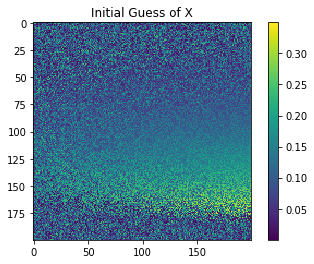

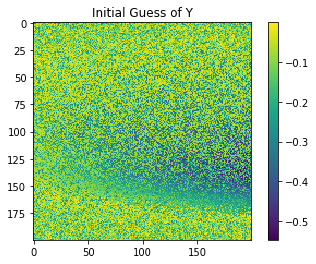

In [1166]:
plt.imshow(trainer.model(trainx).data[:,0].reshape(S.shape))
plt.title('Initial Guess of X')
plt.colorbar()
plt.figure()
plt.imshow(trainer.model(trainx).data[:,1].reshape(S.shape))
plt.title('Initial Guess of Y')
plt.colorbar()

In [1022]:
trainer.optimizer.update?

In [1217]:
loss_hist = trainer.run_train(trainx, trainy, epoch=10000, report_period=10, report_period_seconds=1)

[10/964] loss 0.06810476 , ups: 3.70 , eta: 45:01.67
[20/974] loss 0.068094775 , ups: 3.75 , eta: 44:19.05
[30/984] loss 0.06812299 , ups: 3.76 , eta: 44:08.50
[40/994] loss 0.06809518 , ups: 3.77 , eta: 44:01.26
[50/1004] loss 0.06807699 , ups: 3.76 , eta: 44:08.76
[60/1014] loss 0.06806551 , ups: 3.75 , eta: 44:09.35
[70/1024] loss 0.06806095 , ups: 3.78 , eta: 43:48.45
[80/1034] loss 0.068050824 , ups: 3.78 , eta: 43:43.81
[90/1044] loss 0.068048365 , ups: 3.79 , eta: 43:34.29
[100/1054] loss 0.06805634 , ups: 3.79 , eta: 43:31.79
[110/1064] loss 0.06803214 , ups: 3.80 , eta: 43:25.56
[120/1074] loss 0.06802666 , ups: 3.80 , eta: 43:18.22
[130/1084] loss 0.06801988 , ups: 3.80 , eta: 43:16.84
[140/1094] loss 0.068015054 , ups: 3.80 , eta: 43:16.31
[150/1104] loss 0.068007596 , ups: 3.80 , eta: 43:13.17
[160/1114] loss 0.06802579 , ups: 3.80 , eta: 43:07.80
[170/1124] loss 0.0680072 , ups: 3.80 , eta: 43:05.07
[180/1134] loss 0.06799915 , ups: 3.80 , eta: 43:01.91
[190/1144] loss 0.0

[1500/2454] loss 0.0676842 , ups: 3.67 , eta: 38:37.55
[1510/2464] loss 0.06767345 , ups: 3.67 , eta: 38:35.40
[1520/2474] loss 0.067670025 , ups: 3.67 , eta: 38:33.76
[1530/2484] loss 0.06770147 , ups: 3.66 , eta: 38:31.31
[1540/2494] loss 0.06767941 , ups: 3.66 , eta: 38:29.16
[1550/2504] loss 0.067669824 , ups: 3.66 , eta: 38:27.37
[1560/2514] loss 0.06766654 , ups: 3.66 , eta: 38:25.46
[1570/2524] loss 0.0676676 , ups: 3.66 , eta: 38:23.50
[1580/2534] loss 0.06766337 , ups: 3.66 , eta: 38:21.60
[1590/2544] loss 0.06766706 , ups: 3.66 , eta: 38:19.32
[1600/2554] loss 0.06766543 , ups: 3.66 , eta: 38:17.33
[1610/2564] loss 0.06767329 , ups: 3.65 , eta: 38:15.75
[1620/2574] loss 0.067709126 , ups: 3.65 , eta: 38:14.07
[1630/2584] loss 0.067666605 , ups: 3.65 , eta: 38:11.91
[1640/2594] loss 0.06765558 , ups: 3.65 , eta: 38:09.83
[1650/2604] loss 0.06766552 , ups: 3.65 , eta: 38:07.80
[1660/2614] loss 0.06765314 , ups: 3.65 , eta: 38:05.90
[1670/2624] loss 0.06766282 , ups: 3.65 , eta:

[2960/3914] loss 0.06755514 , ups: 3.58 , eta: 32:48.75
[2970/3924] loss 0.067558214 , ups: 3.58 , eta: 32:46.07
[2980/3934] loss 0.06756382 , ups: 3.58 , eta: 32:43.51
[2990/3944] loss 0.067591146 , ups: 3.58 , eta: 32:40.65
[3000/3954] loss 0.06754715 , ups: 3.57 , eta: 32:38.10
[3010/3964] loss 0.06755741 , ups: 3.57 , eta: 32:35.33
[3020/3974] loss 0.06756575 , ups: 3.57 , eta: 32:32.86
[3030/3984] loss 0.06755713 , ups: 3.57 , eta: 32:30.29
[3040/3994] loss 0.067545444 , ups: 3.57 , eta: 32:27.72
[3050/4004] loss 0.06755276 , ups: 3.57 , eta: 32:25.20
[3060/4014] loss 0.06767797 , ups: 3.57 , eta: 32:22.26
[3070/4024] loss 0.06756974 , ups: 3.57 , eta: 32:19.52
[3080/4034] loss 0.067548804 , ups: 3.57 , eta: 32:16.80
[3090/4044] loss 0.06754079 , ups: 3.57 , eta: 32:14.30
[3100/4054] loss 0.067540064 , ups: 3.57 , eta: 32:11.69
[3110/4064] loss 0.06754347 , ups: 3.57 , eta: 32:09.16
[3120/4074] loss 0.06754064 , ups: 3.57 , eta: 32:06.42
[3130/4084] loss 0.06753927 , ups: 3.57 , e

[4420/5374] loss 0.06747898 , ups: 3.53 , eta: 26:19.13
[4430/5384] loss 0.06748091 , ups: 3.53 , eta: 26:16.36
[4440/5394] loss 0.0674803 , ups: 3.53 , eta: 26:13.58
[4450/5404] loss 0.06754001 , ups: 3.53 , eta: 26:10.92
[4460/5414] loss 0.06750648 , ups: 3.53 , eta: 26:08.21
[4470/5424] loss 0.06751182 , ups: 3.53 , eta: 26:05.37
[4480/5434] loss 0.06748115 , ups: 3.53 , eta: 26:02.63
[4490/5444] loss 0.06747627 , ups: 3.53 , eta: 25:59.91
[4500/5454] loss 0.06747245 , ups: 3.53 , eta: 25:57.12
[4510/5464] loss 0.06749129 , ups: 3.53 , eta: 25:54.41
[4520/5474] loss 0.067547284 , ups: 3.53 , eta: 25:51.65
[4530/5484] loss 0.067470066 , ups: 3.53 , eta: 25:48.94
[4540/5494] loss 0.06749948 , ups: 3.53 , eta: 25:46.23
[4550/5504] loss 0.06746974 , ups: 3.53 , eta: 25:43.48
[4560/5514] loss 0.067477904 , ups: 3.53 , eta: 25:40.68
[4570/5524] loss 0.06754196 , ups: 3.53 , eta: 25:37.87
[4580/5534] loss 0.067483924 , ups: 3.53 , eta: 25:35.11
[4590/5544] loss 0.06749244 , ups: 3.53 , eta

[5890/6844] loss 0.067431845 , ups: 3.51 , eta: 19:30.94
[5900/6854] loss 0.06745071 , ups: 3.51 , eta: 19:28.10
[5910/6864] loss 0.06743183 , ups: 3.51 , eta: 19:25.32
[5920/6874] loss 0.067440696 , ups: 3.51 , eta: 19:22.47
[5930/6884] loss 0.06743148 , ups: 3.51 , eta: 19:19.69
[5940/6894] loss 0.06744144 , ups: 3.51 , eta: 19:16.92
[5950/6904] loss 0.06752966 , ups: 3.51 , eta: 19:14.10
[5960/6914] loss 0.06742773 , ups: 3.51 , eta: 19:11.30
[5970/6924] loss 0.067450956 , ups: 3.51 , eta: 19:08.52
[5980/6934] loss 0.06743159 , ups: 3.51 , eta: 19:05.70
[5990/6944] loss 0.06743663 , ups: 3.51 , eta: 19:02.93
[6000/6954] loss 0.067424946 , ups: 3.51 , eta: 19:00.20
[6010/6964] loss 0.06742683 , ups: 3.51 , eta: 18:57.33
[6020/6974] loss 0.067483835 , ups: 3.51 , eta: 18:54.57
[6030/6984] loss 0.06754924 , ups: 3.51 , eta: 18:51.75
[6040/6994] loss 0.06746864 , ups: 3.51 , eta: 18:48.97
[6050/7004] loss 0.06743776 , ups: 3.51 , eta: 18:46.21
[6060/7014] loss 0.067431174 , ups: 3.51 , 

[7350/8304] loss 0.067634255 , ups: 3.49 , eta: 12:38.35
[7360/8314] loss 0.06748161 , ups: 3.49 , eta: 12:35.52
[7370/8324] loss 0.06742737 , ups: 3.49 , eta: 12:32.75
[7380/8334] loss 0.067408554 , ups: 3.49 , eta: 12:29.92
[7390/8344] loss 0.06739955 , ups: 3.49 , eta: 12:27.08
[7400/8354] loss 0.067393884 , ups: 3.49 , eta: 12:24.26
[7410/8364] loss 0.06739826 , ups: 3.49 , eta: 12:21.45
[7420/8374] loss 0.06740547 , ups: 3.49 , eta: 12:18.62
[7430/8384] loss 0.06741899 , ups: 3.49 , eta: 12:15.80
[7440/8394] loss 0.06745687 , ups: 3.49 , eta: 12:12.99
[7450/8404] loss 0.06740915 , ups: 3.49 , eta: 12:10.18
[7460/8414] loss 0.067396805 , ups: 3.49 , eta: 12:07.36
[7470/8424] loss 0.06743901 , ups: 3.49 , eta: 12:04.56
[7480/8434] loss 0.0674726 , ups: 3.49 , eta: 12:01.73
[7490/8444] loss 0.06740628 , ups: 3.49 , eta: 11:58.90
[7500/8454] loss 0.06741478 , ups: 3.49 , eta: 11:56.07
[7510/8464] loss 0.06739222 , ups: 3.49 , eta: 11:53.25
[7520/8474] loss 0.06741189 , ups: 3.49 , eta

[8830/9784] loss 0.06737681 , ups: 3.46 , eta: 5:37.99
[8840/9794] loss 0.06742318 , ups: 3.46 , eta: 5:35.12
[8850/9804] loss 0.06753759 , ups: 3.46 , eta: 5:32.25
[8860/9814] loss 0.06743782 , ups: 3.46 , eta: 5:29.38
[8870/9824] loss 0.06739088 , ups: 3.46 , eta: 5:26.52
[8880/9834] loss 0.067373 , ups: 3.46 , eta: 5:23.65
[8890/9844] loss 0.06738115 , ups: 3.46 , eta: 5:20.78
[8900/9854] loss 0.06737388 , ups: 3.46 , eta: 5:17.92
[8910/9864] loss 0.06737451 , ups: 3.46 , eta: 5:15.04
[8920/9874] loss 0.067422464 , ups: 3.46 , eta: 5:12.17
[8930/9884] loss 0.0675118 , ups: 3.46 , eta: 5:09.29
[8940/9894] loss 0.06742213 , ups: 3.46 , eta: 5:06.41
[8950/9904] loss 0.067376174 , ups: 3.46 , eta: 5:03.55
[8960/9914] loss 0.067380376 , ups: 3.46 , eta: 5:00.67
[8970/9924] loss 0.06737572 , ups: 3.46 , eta: 4:57.80
[8980/9934] loss 0.06738898 , ups: 3.46 , eta: 4:54.92
[8990/9944] loss 0.06740757 , ups: 3.46 , eta: 4:52.06
[9000/9954] loss 0.067404635 , ups: 3.46 , eta: 4:49.18
[9010/996

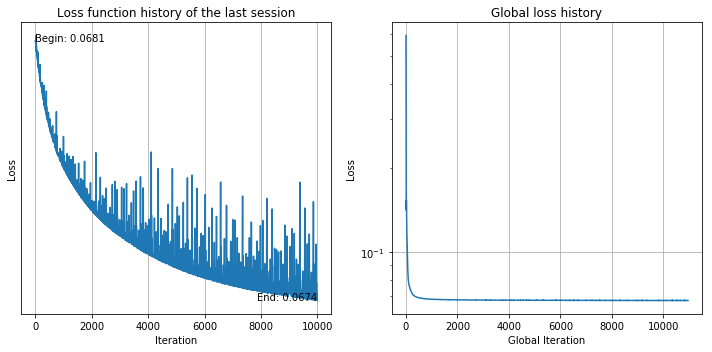

In [1218]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].semilogy(range(len(loss_hist)), loss_hist)
ax[0].annotate('Begin: {:.4f}'.format(loss_hist[0]), xy=(0,loss_hist[0]), xytext=(0,loss_hist[0]))
ax[0].annotate('End: {:.4f}'.format(loss_hist[-1]), xy=(len(loss_hist),loss_hist[-1]), xytext=(len(loss_hist),loss_hist[-1]), horizontalalignment='right')
ax[0].grid()
ax[0].set_title('Loss function history of the last session')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Loss')
ax[1].semilogy(range(len(trainer.loss_hist)), trainer.loss_hist)
ax[1].grid()
ax[1].set_title('Global loss history')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Global Iteration')
plt.tight_layout()

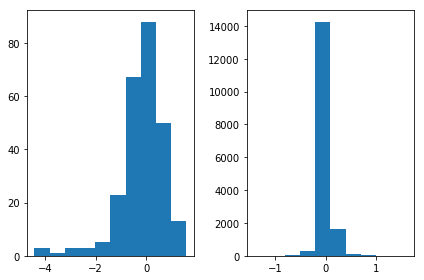

In [1219]:
fig, ax = plt.subplots(1,2)
ax[0].hist(trainer.model.l1.W.data.flat)
ax[1].hist(trainer.model.l2.W.data.flat);
#plt.plot(trainer.model.l2.W.data.flat)
plt.tight_layout()

(100, 100) (100, 100) float64 float64
756.994903087616 0.7694153
747.2822666168213 0.45141453
760.7114315032959 0.7143968
714.1772508621216 0.440833
751.2335181236267 0.60582626
740.6483292579651 0.5334857
711.4393711090088 0.81779176
730.1837205886841 0.1865301


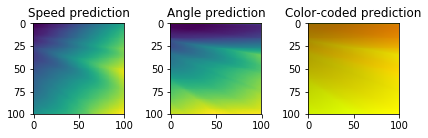

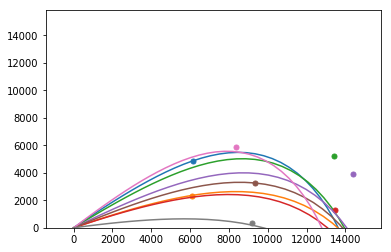

In [1223]:
def test_model():
    #speeds = np.arange(700,1700,10,dtype=np.float32) / speed_scale
    #thetas = np.linspace(0,np.pi/3,100,dtype=np.float32)
    x, y = np.linspace(5000,10000,100), np.linspace(0,10000,100)
    #print(len(speeds), len(thetas), speeds.max(), thetas.max())
    #S, T = np.meshgrid(speeds, thetas)
    #print(S.shape, T.shape, S.dtype, T.dtype)
    #ST = np.vstack([S.flat, T.flat]).astype(np.float32).T
    X, Y = np.meshgrid(x, y)
    XY = np.vstack([X.flat, Y.flat]).astype(np.float32).T / position_scale
    print(X.shape, Y.shape, X.dtype, Y.dtype)
    #predicty = trainer.model(ST)
    #print(predicty.shape, S.shape, predicty.data)
    predicty = trainer.model(XY)
    predictrgb = np.hstack([predicty.data / predicty.data.max(0), np.zeros((predicty.data.shape[0],1),dtype=np.float32)])
    fig, ax = plt.subplots(1,3)
    ax[0].imshow(predicty.data[:,0].reshape(X.shape))
    ax[0].set_title('Speed prediction')
    ax[1].imshow(predicty.data[:,1].reshape(X.shape))
    ax[1].set_title('Angle prediction')
    ax[2].imshow(predictrgb.reshape((X.shape[0], X.shape[1], 3)))
    ax[2].set_title('Color-coded prediction')
    plt.tight_layout()
    #plt.colorbar()

    plt.figure()
    #ST = np.hstack([np.random.rand(6,1) * 1000 + 700, np.random.rand(6,1) * np.pi/3])
    XY = np.hstack([np.random.rand(8,1) * 10000 + 5000, np.random.rand(8,1) * 10000])
    #targetx = 15000
    for xy in XY:
        st_predict = trainer.model(np.array((xy[0] - position_scale, xy[1]), dtype=np.float32).reshape((1,-1)) / position_scale).data[0]
        #print(st_predict)
        speed, theta = st_predict[0] * speed_scale, st_predict[1]
        print(speed, theta)
        trajectory, dist = trace_trajectory(speed * np.cos(theta), speed * np.sin(theta), targetx=xy[0], drag=1e-4)
        lines = plt.plot(trajectory[:,0], trajectory[:,1])
        plt.plot(xy[0], xy[1], '.', ms=10, color=lines[0].get_color())
        #plt.plot(xy[0], dist_predict, 'x', ms=10)
    plt.xlim(xmin=-XY[:,0].max() * .1, xmax=XY[:,0].max() * 1.1)
    plt.ylim(ymin=0,ymax=XY[:,0].max() * 1.1)
    #for _,theta in ST:
#        trajectory, dist = trace_trajectory(speed * np.cos(theta), speed * np.sin(theta), targetx=targetx, drag=0)
#        plt.plot(trajectory[:,0], trajectory[:,1], '--')

test_model()